In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re
import folium
from folium import plugins
import seaborn as sns
import matplotlib.pyplot as plt

# LIMPIEZA DE DATOS

In [ ]:
#mandamos llamar el archivo
casos_mexico = pd.read_csv('/content/drive/MyDrive/PROYECTO_AFLUENCIA_VUELOS_IRONHACK/201130COVID19MEXICO.csv', encoding="ISO-8859-1")

In [ ]:
#vemos el tipo de achivos que tenemos
casos_mexico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2866225 entries, 0 to 2866224
Data columns (total 40 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   FECHA_ACTUALIZACION    object        
 1   ID_REGISTRO            object        
 2   ORIGEN                 int64         
 3   SECTOR                 int64         
 4   ENTIDAD_UM             int64         
 5   SEXO                   int64         
 6   ENTIDAD_NAC            int64         
 7   ENTIDAD_RES            int64         
 8   MUNICIPIO_RES          int64         
 9   TIPO_PACIENTE          int64         
 10  FECHA_INGRESO          datetime64[ns]
 11  FECHA_SINTOMAS         object        
 12  FECHA_DEF              object        
 13  INTUBADO               int64         
 14  NEUMONIA               int64         
 15  EDAD                   int64         
 16  NACIONALIDAD           int64         
 17  EMBARAZO               int64         
 18  HABLA_LENGUA_INDIG    

In [ ]:
#vamos a convertir la columna fecha_ingreso a un formato de datetime64, ya que esta es la fecha que nos define cuando se
#reporto ante los centros de salud el caso
casos_mexico['FECHA_INGRESO'] = casos_mexico['FECHA_INGRESO'].values.astype('datetime64')

In [ ]:
#revisamos de nuevo
#casos_mexico.info()

In [ ]:
#casos_mexico.head(3)

In [ ]:
#Empezaremos eliminando las columnas que para este análisis no necesitamos
casos_mexico_tabla = casos_mexico.drop(['FECHA_ACTUALIZACION','ORIGEN','ENTIDAD_UM','MIGRANTE','ENTIDAD_NAC'], axis=1).reset_index(drop=True)

In [ ]:
#verificamos la cantidad de rows que tenemos
len(casos_mexico_tabla)

2866225

In [ ]:
#verificamos de esta base cuándo fue la fecha de los ultimos ingresos registrados
casos_mexico_tabla['FECHA_INGRESO'].max()

Timestamp('2020-11-30 00:00:00')

In [ ]:
#verificaremos si hay ID repetidos, confirmamos que son únicos
unicos = casos_mexico_tabla['ID_REGISTRO'].value_counts() 

In [ ]:
unicos[unicos>1]

Series([], Name: ID_REGISTRO, dtype: int64)

In [ ]:
len(unicos)

2866225

In [ ]:
#Cambiamos el diccionario de datos, para saber cada valor, empezamos co el de sexo
casos_mexico_tabla['SEXO'] = casos_mexico_tabla['SEXO'].replace({1:"Femenino" , 2: "Masculino", 99:"NE"})

In [ ]:
#Verificamos que las entidades sean todas iguales, es decir que no haya 3 y 03, 
ENTIDAD = casos_mexico_tabla['ENTIDAD_RES'].value_counts() 
#ENTIDAD

In [ ]:
#cambiamos el nombre de las entidades de méxico
casos_mexico_tabla['ENTIDAD_RES'] = casos_mexico_tabla['ENTIDAD_RES'].replace({1:"Aguascalientes" , 2: "Baja California", 3:"Baja California Sur",4:"Campeche" ,5:"Coahuila" ,6:"Colima" ,7:"Chiapas" ,8:"Chihuahua" ,9:"Distrito Federal" ,10:"Durango" ,11:"Guanajuato" ,12:"Guerrero" ,13:"Hidalgo" ,14:"Jalisco" ,15:"México" ,16:"Michoacán" ,17:"Morelos" ,18:"Nayarit" ,19:"Nuevo León" ,20:"Oaxaca" ,21:"Puebla" ,22:"Querétaro" ,23:"Quintana Roo" ,24:"San Luis Potosí" ,25:"Sinaloa" ,26:"Sonora" ,27:"Tabasco" ,28:"Tamaulipas" ,29:"Tlaxcala" ,30:"Veracruz" ,31:"Yucatán",32:"Zacatecas", 36:"Estados Unidos Mexicanos", 97:"No aplica", 98:"Se ignora", 99:"No especificado" })

In [ ]:
#Volvemos a verificar que no se haya uedado niguna entidad sin modificar, y de igual manera podemos ver que no hay ningun dato sin estado, 
ENTIDAD = casos_mexico_tabla['ENTIDAD_RES'].value_counts() 
ENTIDAD

Distrito Federal       658363
México                 317986
Guanajuato             157094
Nuevo León             155564
Jalisco                110602
Coahuila               104689
Puebla                  99588
Tabasco                 94579
Tamaulipas              91565
San Luis Potosí         84423
Sonora                  80713
Veracruz                77213
Baja California         73167
Michoacán               70578
Yucatán                 58023
Chihuahua               56477
Sinaloa                 54104
Durango                 49720
Querétaro               46508
Aguascalientes          46307
Guerrero                45090
Chiapas                 43195
Baja California Sur     42468
Oaxaca                  38694
Hidalgo                 37738
Zacatecas               34413
Quintana Roo            30415
Tlaxcala                30222
Morelos                 22297
Campeche                20892
Nayarit                 18350
Colima                  15188
Name: ENTIDAD_RES, dtype: int64

In [ ]:
#Limpiamos la columna país nacionalidad
casos_mexico_tabla['PAIS_NACIONALIDAD'] = casos_mexico_tabla['PAIS_NACIONALIDAD'].replace({'MÃ©xico':"México",'Estados Unidos de AmÃ©rica': "Estados Unidos de América"})

In [ ]:
casos_mexico_tabla['PAIS_NACIONALIDAD'].value_counts() 

México                                           2852444
Estados Unidos de América                           3496
Venezuela                                           1384
Colombia                                            1364
Cuba                                                 759
                                                  ...   
Zaire                                                  1
Estado de Kuwait                                       1
Nepal                                                  1
Islas VÃ­rgenes de Estados Unidos de AmÃ©rica          1
AntÃ¡rtica                                             1
Name: PAIS_NACIONALIDAD, Length: 139, dtype: int64

In [ ]:
#cambiamos los valores de la clasificación de casos para dejarlos en Positivo == 1 o Negativo == 0
casos_mexico_tabla['CLASIFICACION_FINAL'] = casos_mexico_tabla['CLASIFICACION_FINAL'].replace({7:0 , 1:1, 2:1,3:1 ,4:0 ,5:0 ,6:"NaN"})

In [ ]:
#checamos el número de casos
clas_final = casos_mexico_tabla['CLASIFICACION_FINAL'].value_counts() 
clas_final

0      1411714
1      1113543
NaN     340968
Name: CLASIFICACION_FINAL, dtype: int64

In [ ]:
#checamos el min y maximo de edades
edad = casos_mexico_tabla['EDAD'].value_counts() 
edad

30     72919
28     70407
29     69621
31     69303
27     68621
       ...  
114        6
119        5
116        4
113        2
111        2
Name: EDAD, Length: 121, dtype: int64

In [ ]:
#Ahora cambiamos para cada enfermedad los valores Positivo == 1 o Negativo == 0, para datos que se ignoren, no apliquen o no esté
#especificado, se determinará con un Negativo(0), ya que no podemos borrar esas filas puesto que otros datos si podrían
#tener información
casos_mexico_tabla['EMBARAZO'] = casos_mexico_tabla['EMBARAZO'].replace({2:0 , 97:0, 98:0,99:0})
casos_mexico_tabla['DIABETES'] = casos_mexico_tabla['DIABETES'].replace({2:0 , 97:0, 98:0,99:0})
casos_mexico_tabla['EPOC'] = casos_mexico_tabla['EPOC'].replace({2:0 , 97:0, 98:0,99:0})
casos_mexico_tabla['ASMA'] = casos_mexico_tabla['ASMA'].replace({2:0 , 97:0, 98:0,99:0})
casos_mexico_tabla['INMUSUPR'] = casos_mexico_tabla['INMUSUPR'].replace({2:0 , 97:0, 98:0,99:0})
casos_mexico_tabla['HIPERTENSION'] = casos_mexico_tabla['HIPERTENSION'].replace({2:0 , 97:0, 98:0,99:0})
casos_mexico_tabla['CARDIOVASCULAR'] = casos_mexico_tabla['CARDIOVASCULAR'].replace({2:0 , 97:0, 98:0,99:0})
casos_mexico_tabla['OBESIDAD'] = casos_mexico_tabla['OBESIDAD'].replace({2:0 , 97:0, 98:0,99:0})
casos_mexico_tabla['RENAL_CRONICA'] = casos_mexico_tabla['RENAL_CRONICA'].replace({2:0 , 97:0, 98:0,99:0})
casos_mexico_tabla['TABAQUISMO'] = casos_mexico_tabla['TABAQUISMO'].replace({2:0 , 97:0, 98:0,99:0})
casos_mexico_tabla['OTRA_COM'] = casos_mexico_tabla['OTRA_COM'].replace({2:0 , 97:0, 98:0,99:0})
casos_mexico_tabla['INTUBADO'] = casos_mexico_tabla['INTUBADO'].replace({2:0 , 97:0, 98:0,99:0})
casos_mexico_tabla['NEUMONIA'] = casos_mexico_tabla['NEUMONIA'].replace({2:0 , 97:0, 98:0,99:0})

In [ ]:
#Ahora sumamos todos los resultados de las enfermedades, esto por fila, y lo agregamos a una columna para que después podamos analizar si als personas con mayor
#cantidad de enenfermedades son más prpensos a padecer COVID
casos_mexico_tabla['TOTAL_PADECIMIENTO'] = casos_mexico_tabla[["NEUMONIA","DIABETES", "EPOC", "ASMA","INMUSUPR","HIPERTENSION","CARDIOVASCULAR","OBESIDAD","RENAL_CRONICA","TABAQUISMO","OTRA_COM"]].sum(axis=1)

In [ ]:
#Ahora para detectar a las personas fallecidas, remplazamos los datos con Positivo == 1 o Negativo == 0
casos_mexico_tabla['FECHA_DEF'] = casos_mexico_tabla['FECHA_DEF'].replace({"9999-99-99":0})
casos_mexico_tabla['FECHA_DEF'].value_counts()

0    2716957
1     149268
Name: FECHA_DEF, dtype: int64

In [ ]:
#Ahora reeemplazamos las personas que si fallecieron con el numero 1
casos_mexico_tabla['FECHA_DEF'] = casos_mexico_tabla['FECHA_DEF'].replace(to_replace=r'^2020*', value=1, regex=True)

In [ ]:
#casos_mexico_tabla.head()

In [ ]:
#ahora definimos por tipo de paciente amblatorio, hospitalizado y no especificado
casos_mexico_tabla['TIPO_PACIENTE'] = casos_mexico_tabla['TIPO_PACIENTE'].replace({1:"Ambulatorio" , 2: "Hospitalizado", 99:"NE"})

In [ ]:
#Guardamos la base con todos los datos, ya que ahora ya está trabajada y limpia
#casos_mexico_tabla.to_csv('/content/drive/MyDrive/PROYECTO_AFLUENCIA_VUELOS_IRONHACK/casos_mexico_tabla_limpia.csv',index=False)

CREACIÓN DE BASE DATOS SOSPECHOSOS

In [ ]:
#creamos una tabla con los casos sospechosos
casos_mexico_tabla_sos = casos_mexico_tabla[casos_mexico_tabla['CLASIFICACION_FINAL']=='NaN']

In [ ]:
casos_mexico_tabla_sos['CLASIFICACION_FINAL'].value_counts()

NaN    340968
Name: CLASIFICACION_FINAL, dtype: int64

In [ ]:
# creamos una lista con las edades mayores a 101, posterior eliminamos esos datos, ya que si los convirtieramos a edades de 100
#podrían mover la aguja de las gráficas
edad_mas_noventa = list(casos_mexico_tabla_sos[casos_mexico_tabla_sos['EDAD']>=101].index)


In [ ]:
#Eliminamos los casos con la lista creada, ahora tenemos de resultado 340,897 rows de las 340,968 que teníamos 
casos_mexico_tabla_sos_g = casos_mexico_tabla_sos.drop(edad_mas_noventa, axis=0)

In [ ]:
len(casos_mexico_tabla_sos_g)

340897

In [ ]:
#guardamos la base para usarla posteriormente
#casos_mexico_tabla_sos_g.to_csv('/content/drive/MyDrive/PROYECTO_AFLUENCIA_VUELOS_IRONHACK/casos_mexico_tabla_sos_g.csv',index=False)

In [ ]:
#creamos un groupby por fecha y por estado, obteniendo 9,801 datos 
casos_mexico_tabla_sos_g = casos_mexico_tabla_sos.groupby( by = ['FECHA_INGRESO','ENTIDAD_RES']).agg({'CLASIFICACION_FINAL':'count'}).reset_index()

In [ ]:
#le agrego una columna más extrayendo el mes(esto porque despues la ocuparé para exportar la base)
casos_mexico_tabla_sos_g['MES'] = casos_mexico_tabla_sos_g['FECHA_INGRESO'].dt.month

In [ ]:
casos_mexico_tabla_sos_g

,FECHA_INGRESO,ENTIDAD_RES,CLASIFICACION_FINAL,MES
0,2020-01-01,Distrito Federal,1,1
1,2020-01-01,México,1,1
2,2020-01-01,Nayarit,1,1
3,2020-01-01,Nuevo León,2,1
4,2020-01-01,Sonora,1,1
...,...,...,...,...
9796,2020-11-30,Tabasco,3,11
9797,2020-11-30,Tamaulipas,2,11
9798,2020-11-30,Tlaxcala,1,11
9799,2020-11-30,Veracruz,7,11


In [ ]:
#hacemos un groupby por el mes y dibujamos de nuevo el mapa
casos_mexico_tabla_sos_gm = casos_mexico_tabla_sos_g.groupby('ENTIDAD_RES')['CLASIFICACION_FINAL'].sum().reset_index()
#Convertimos el archivo en un CSV
#casos_mexico_tabla_sos_gm.to_csv('/content/drive/MyDrive/PROYECTO_AFLUENCIA_VUELOS_IRONHACK/casos_mexico_tabla_sos_gm.csv',index=False)

CREACIÓN DE BASE DE DATOS POSITIVOS

In [ ]:
#creamos una nueva tabla sólo con los casos positivos
casos_mexico_tabla_positivos = casos_mexico_tabla[casos_mexico_tabla.CLASIFICACION_FINAL == 1]

In [ ]:
#Revisamos
len(casos_mexico_tabla_positivos)

1113543

In [ ]:
# creamos una lista con las edades mayores a 101, posterior eliminamos esos datos, ya que si los convirtieramos a edades de 100
#podrían mover la aguja de las gráficas
edad_mas_noventa = list(casos_mexico_tabla_positivos[casos_mexico_tabla_positivos['EDAD']>=101].index)
#Eliminamos los casos con la lista creada, De los 1,113,543 que teníamos, ahora nos quedamos con 1,113,421
casos_mexico_tabla_pos_g = casos_mexico_tabla_positivos.drop(edad_mas_noventa, axis=0)
#len(casos_mexico_tabla_pos_g)

1113421

In [ ]:
casos_mexico_tabla_pos_g['EDAD'].value_counts()

30     25870
31     24913
37     24688
29     24495
34     24402
       ...  
96       175
97       139
98       127
99        83
100       69
Name: EDAD, Length: 101, dtype: int64

In [ ]:
#Guardamos la base para poder usarla posteriormente ya limpia
#casos_mexico_tabla_pos_g.to_csv('/content/drive/MyDrive/PROYECTO_AFLUENCIA_VUELOS_IRONHACK/casos_mexico_tabla_pos_g.csv',index=False)

In [ ]:
#creamos un groupby por fecha y por estado
casos_mexico_tabla_pos_gm = casos_mexico_tabla_pos_g.groupby( by= ['FECHA_INGRESO','ENTIDAD_RES']).agg({'CLASIFICACION_FINAL':'count'}).reset_index()
casos_mexico_tabla_pos_gm

,FECHA_INGRESO,ENTIDAD_RES,CLASIFICACION_FINAL
0,2020-01-13,Nuevo León,1
1,2020-01-28,Sinaloa,1
2,2020-01-29,Sinaloa,1
3,2020-02-10,Querétaro,1
4,2020-02-24,Chihuahua,1
...,...,...,...
8161,2020-11-29,Sinaloa,8
8162,2020-11-29,Sonora,1
8163,2020-11-29,Zacatecas,24
8164,2020-11-30,Distrito Federal,2


In [ ]:
#probé hacer un pivot table, pero me combiene más hacerlo por groupby 
#pt = pd.pivot_table(
#    casos_mexico_tabla_positivos, 
#    index=['FECHA_INGRESO', 'ENTIDAD_RES'], 
#    values=['CLASIFICACION_FINAL'], 
#    aggfunc={'CLASIFICACION_FINAL':'count'}
#)

In [ ]:
#le agrego una columna más extrayendo el mes(esto porque despues la ocuparé para exportar la base)
casos_mexico_tabla_pos_gm['MES'] = casos_mexico_tabla_pos_gm['FECHA_INGRESO'].dt.month

In [ ]:
casos_mexico_tabla_pos_gm.head()

,FECHA_INGRESO,ENTIDAD_RES,CLASIFICACION_FINAL,MES
0,2020-01-13,Nuevo León,1,1
1,2020-01-28,Sinaloa,1,1
2,2020-01-29,Sinaloa,1,1
3,2020-02-10,Querétaro,1,2
4,2020-02-24,Chihuahua,1,2


In [ ]:
#descargamos esta base creada, esto para el dashboard que se creará en otra plataforma
#casos_mexico_tabla_pos_gm.to_csv('/content/drive/MyDrive/PROYECTO_AFLUENCIA_VUELOS_IRONHACK/casos_mexico_tabla_pos_gm.csv',index=False)

# CREACIÓN DE MAPAS

MAPA INTERACTIVO DONDE MUESTRA LSO CASOS POSITIVOS DE MANERA HISTÓRICA

In [ ]:
geo_state ='https://gist.githubusercontent.com/ponentesincausa/46d1d9a94ca04a56f93d/raw/a05f4e2b42cf981e31ef9f6f9ee151a060a38c25/mexico.json'
Data_map = pd.read_csv('/content/drive/MyDrive/PROYECTO_AFLUENCIA_VUELOS_IRONHACK/casos_mexico_tabla_pos_gm.csv')
mapa = folium.Map(location=[19, -99], zoom_start=5)
folium.Choropleth(
    geo_data=geo_state,
    name='choropleth',
    data=Data_map,
    columns=['ENTIDAD_RES', 'CLASIFICACION_FINAL'],
    key_on='feature.properties.woe_name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Casos Covid (#)'
).add_to(mapa)

folium.LayerControl().add_to(mapa)

mapa


In [ ]:
#hacemos un groupby por fecha y dibujamos de nuevo el mapa
casos_mexico_tabla_positivos_gm = casos_mexico_tabla_pos_gm.groupby('ENTIDAD_RES')['CLASIFICACION_FINAL'].sum().reset_index()
#casos_mexico_tabla_positivos_gm

In [ ]:
#verificamos que los casos positivos, sumen el más del millón que teniamos anteriormente para positivos
casos_mexico_tabla_positivos_gm['CLASIFICACION_FINAL'].sum()

1113421

In [ ]:
#Convertimos el archivo en un CSV
casos_mexico_tabla_positivos_gm.to_csv('/content/drive/MyDrive/PROYECTO_AFLUENCIA_VUELOS_IRONHACK/casos_mexico_tabla_positivos_gm.csv',index=False)

MAPA CON CASOS POSITIVOS Y SOSPECHOSOS ACUMULADOS HASTA EL 30 DE NOV 2020

In [ ]:
#creación del mapa
#Localizamos un geojson que tuviera ya definidas las figuras de cada estado de México por coordenadas
geo_state ='https://gist.githubusercontent.com/ponentesincausa/46d1d9a94ca04a56f93d/raw/a05f4e2b42cf981e31ef9f6f9ee151a060a38c25/mexico.json'
#Mandamos llamar el archivo csv donde se contienen los datos acumulados por estado positivo y sospechoso
data_mapa_acumulado = pd.read_csv('/content/drive/MyDrive/PROYECTO_AFLUENCIA_VUELOS_IRONHACK/casos_mexico_tabla_positivos_gm.csv')
data_mapa_acumulado_sos = pd.read_csv('/content/drive/MyDrive/PROYECTO_AFLUENCIA_VUELOS_IRONHACK/casos_mexico_tabla_sos_gm.csv')
#definimos el tamaño del mapa y la localización donde se ubicará
mapa1 = folium.Map(location=[19, -99], zoom_start=5)
#realizamos la sintaxis para colorear el mapa por la cantidad de casos positivos 
folium.Choropleth(
    geo_data=geo_state,
    name='Positivos',
    data= data_mapa_acumulado,
    columns=['ENTIDAD_RES', 'CLASIFICACION_FINAL'],
    key_on='feature.properties.woe_name',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Casos Covid Positivos en Miles(#)'
).add_to(mapa1)

#realizamos la sintaxis para colorear el mapa por la cantidad de casos sospechosos

folium.Choropleth(
    geo_data=geo_state,
    name='Sospechosos',
    data= data_mapa_acumulado_sos,
    columns=['ENTIDAD_RES', 'CLASIFICACION_FINAL'],
    key_on='feature.properties.woe_name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Casos Covid Sosechosos (#)'
).add_to(mapa1)

#Agregamos la opción de capa, donde podemos quitar y agregar la coloración sobre el mapa

folium.LayerControl().add_to(mapa1)
#visualizamos el mapa
mapa1
#guardamos el mapa
#mapa1.save("/content/drive/MyDrive/PROYECTO_AFLUENCIA_VUELOS_IRONHACK/mapa1.html")

# CREACION DE GRÁFICAS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re
import folium
from folium import plugins
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#mandamos llamar el archivo
casos_mexico_tabla_pos_g = pd.read_csv('/content/drive/MyDrive/PROYECTO_AFLUENCIA_VUELOS_IRONHACK/casos_mexico_tabla_pos_g.csv')

In [ ]:
#Ahora analizaremos los datos positivos por edad
x = casos_mexico_tabla_pos_g['CLASIFICACION_FINAL']
y = casos_mexico_tabla_pos_g['EDAD']

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


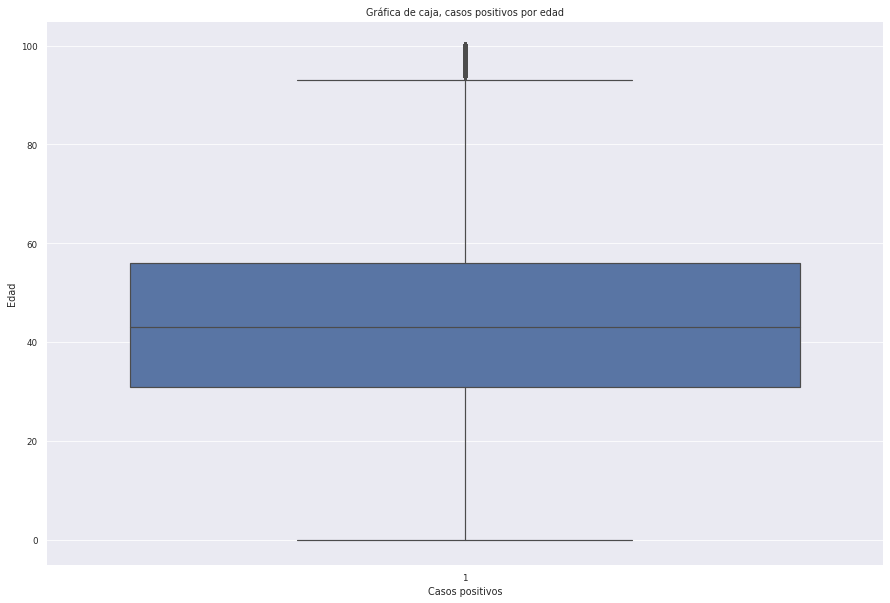

In [ ]:
sns.set(context ='paper', style = 'darkgrid', rc = {'figure.figsize':(15,10)})
ax = sns.boxplot(x,y)
ax.set_title('Gráfica de caja, casos positivos por edad')
ax.set(xlabel ='Casos positivos', ylabel= 'Edad');

Podemos observar que los casos positivos desde febrero a noviembre de 2020, se concentran en las edades de 20 a 56 años (aproximadamente). A pesar de tener aparentemente varios outlayers, anteriormente ya habíamos eliminado las filas con edades mayores a 100 años. Aún así por la cantidad de datos positivos (más de un millon de casos) estos outlayers no afectan el resultado de manera significativa





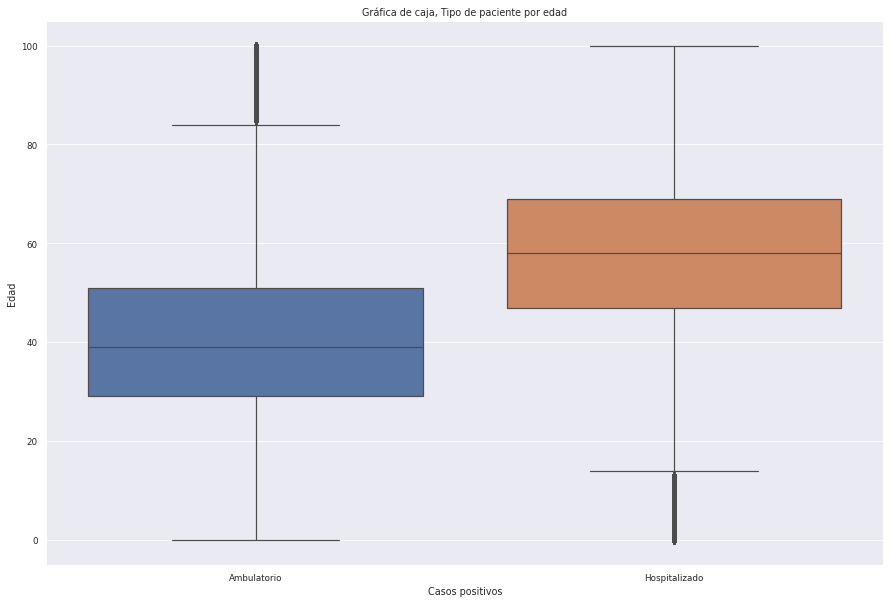

In [ ]:
sns.set(context ='paper', style = 'darkgrid', rc = {'figure.figsize':(15,10)})
ax = sns.boxplot(x = casos_mexico_tabla_pos_g['TIPO_PACIENTE'],y=casos_mexico_tabla_pos_g['EDAD'])
ax.set_title('Gráfica de caja, Tipo de paciente por edad')
ax.set(xlabel ='Casos positivos', ylabel= 'Edad');

Los pacientes que han sido ambilatorios, se encuentran entre los 30 y 50 años vs los que han sido hospitalizados los cuales están entre los 50 y 70 años. Se reafirma que las personas más vulnerables son las personas de la 3ra edad. 

In [ ]:
#casos_mexico_tabla_pos_g.info()

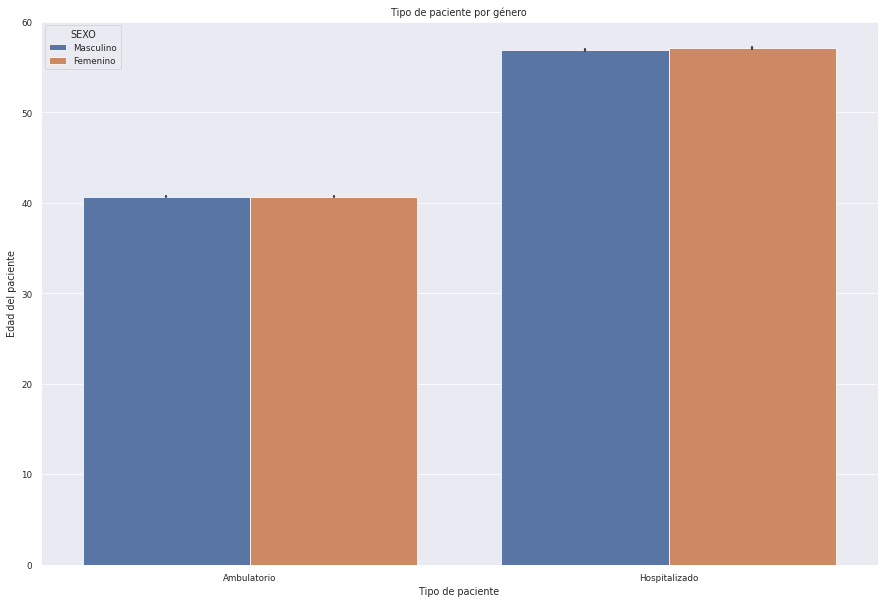

In [ ]:
ax = sns.barplot(data = casos_mexico_tabla_pos_g, x = casos_mexico_tabla_pos_g['TIPO_PACIENTE'].sort_values(), y = casos_mexico_tabla_pos_g['EDAD'], hue = casos_mexico_tabla_pos_g['SEXO'])
#ax = sns.barplot(data = casos_mexico_tabla_pos_g, x = casos_mexico_tabla_pos_g['TIPO_PACIENTE'].sort_values(), y = casos_mexico_tabla_pos_g['CLASIFICACION_FINAL']
ax.set_title("Tipo de paciente por género")
ax.set(xlabel='Tipo de paciente', ylabel='Edad del paciente');


In [ ]:
#mandamos llamar el archivo, la cual es la base original ya trabajada, con toda la informacion
casos_mexico_tabla = pd.read_csv('/content/drive/MyDrive/PROYECTO_AFLUENCIA_VUELOS_IRONHACK/casos_mexico_tabla_limpia.csv')

In [ ]:
#Seleccionamos sólo los casos positvos y negativos para que quede en booleano
casos_mexico_tabla = casos_mexico_tabla[casos_mexico_tabla['CLASIFICACION_FINAL']!='NaN']

In [ ]:
#revisamos que no estén los casos sospechosos, ya que por ahora no los necesitamos
#casos_mexico_tabla['CLASIFICACION_FINAL'].value_counts()

In [ ]:
#preparamos una tabla para poder sacar la correlacion de otras enfermedades con los casos positivos
casos_mexico_tabla_positivos_corr = casos_mexico_tabla[['NEUMONIA','DIABETES','EPOC','ASMA','INMUSUPR','HIPERTENSION','CARDIOVASCULAR','OBESIDAD','RENAL_CRONICA','TABAQUISMO','OTRA_COM','CLASIFICACION_FINAL']]

In [ ]:
#Revisamos que la corelacion si funcione
casos_mexico_tabla_positivos_corr.corr()

,NEUMONIA,DIABETES,EPOC,ASMA,INMUSUPR,HIPERTENSION,CARDIOVASCULAR,OBESIDAD,RENAL_CRONICA,TABAQUISMO,OTRA_COM,CLASIFICACION_FINAL
NEUMONIA,1.000000,0.206993,0.092886,-0.007715,0.058166,0.189602,0.080841,0.069440,0.116747,0.003282,0.065768,0.158835
DIABETES,0.206993,1.000000,0.091244,0.003658,0.047635,0.382954,0.105557,0.116167,0.163604,0.007969,0.037485,0.083894
EPOC,0.092886,0.091244,1.000000,0.034087,0.047493,0.110857,0.102137,0.039712,0.061442,0.054271,0.037186,0.009760
ASMA,-0.007715,0.003658,0.034087,1.000000,0.018876,0.013070,0.017892,0.040631,0.001672,0.003540,0.013520,-0.014520
INMUSUPR,0.058166,0.047635,0.047493,0.018876,1.000000,0.039909,0.054775,0.015569,0.096176,0.007914,0.114242,-0.009199
HIPERTENSION,0.189602,0.382954,0.110857,0.013070,0.039909,1.000000,0.154190,0.163861,0.179659,0.003094,0.052567,0.077981
CARDIOVASCULAR,0.080841,0.105557,0.102137,0.017892,0.054775,0.154190,1.000000,0.052591,0.103139,0.024801,0.063056,0.004450
OBESIDAD,0.069440,0.116167,0.039712,0.040631,0.015569,0.163861,0.052591,1.000000,0.017128,0.073449,0.020666,0.061847
RENAL_CRONICA,0.116747,0.163604,0.061442,0.001672,0.096176,0.179659,0.103139,0.017128,1.000000,0.010275,0.051006,0.009541
TABAQUISMO,0.003282,0.007969,0.054271,0.003540,0.007914,0.003094,0.024801,0.073449,0.010275,1.000000,0.008168,-0.031304


In [ ]:
mask = np.zeros_like(casos_mexico_tabla_positivos_corr.corr(),dtype=np.bool)

In [ ]:
mask[np.triu_indices_from(mask)]=True

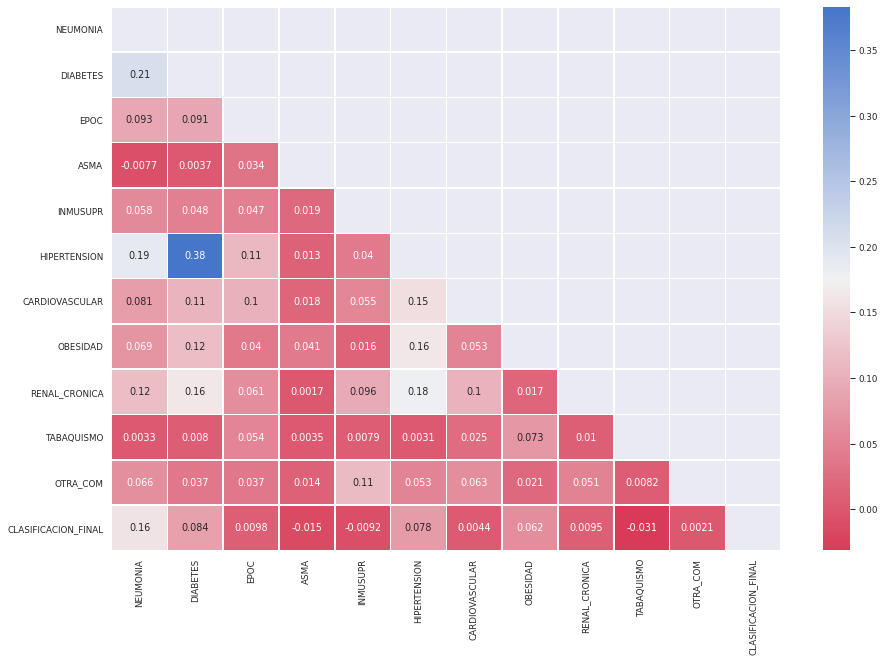

In [ ]:
plt.subplots(figsize=(15,10))
cmap = sns.diverging_palette(6,255,as_cmap=True)
sns.heatmap(casos_mexico_tabla_positivos_corr.corr(),mask=mask,cmap=cmap,linewidths=.5,annot=True)

Podemos observar que lo cosos positivos de COVID, no están más correlacionados a un tipo de padecimiento en especifico, es decir de las 11 enfermedades mostradas, neumonía es la que está mas correlacionada con COVID, aún así, su correlación es muy pequeña

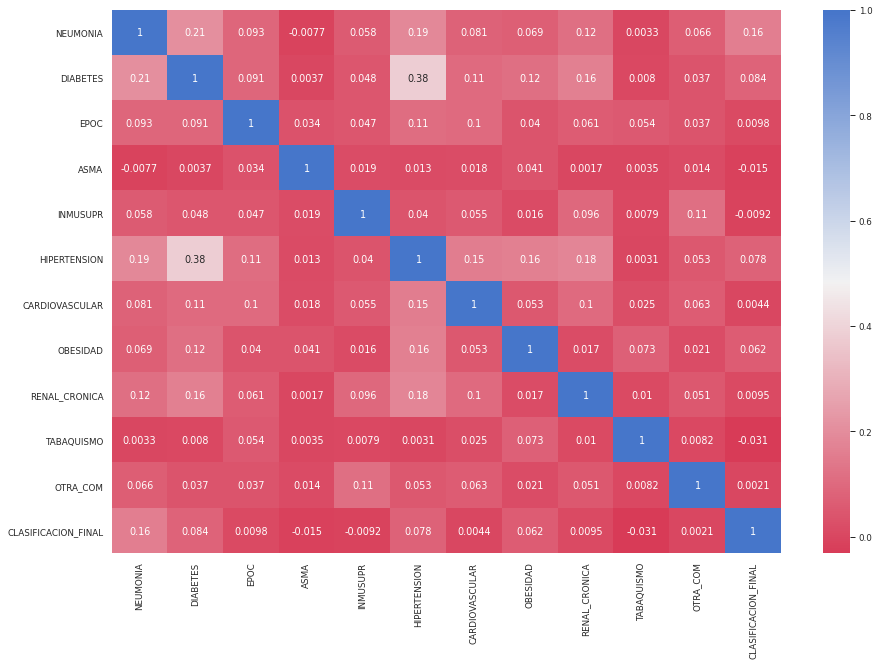

In [ ]:
sns.heatmap(casos_mexico_tabla_positivos_corr.corr(),cmap = cmap, annot=True)

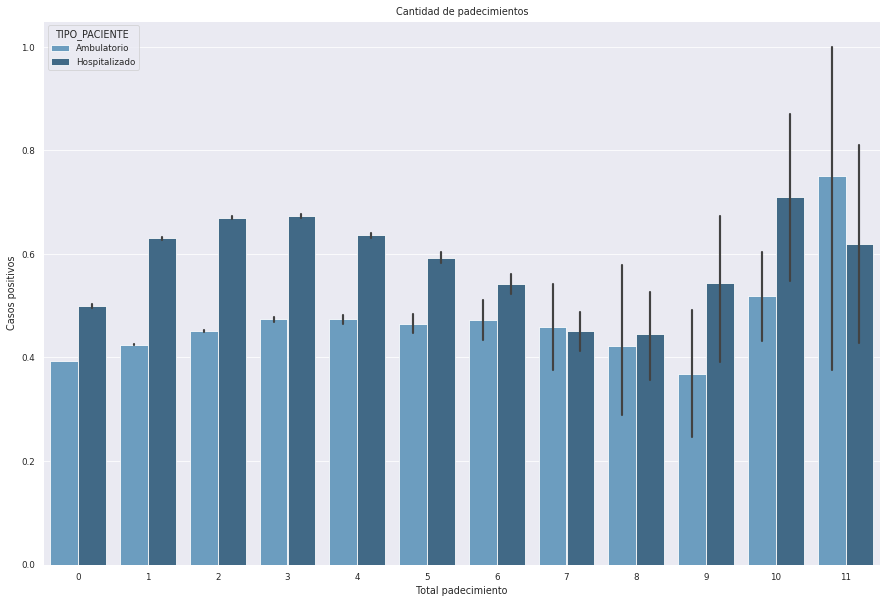

In [ ]:
#ahora realizamos una gráfica de barras donde, mostramos en el eje x, por rango de suma los padecimietos antes mencionados, cruzandolo con
#los pacientes que sean ambulatorios o hayan sido hospitalizados 
ax = sns.barplot(data = casos_mexico_tabla, x = casos_mexico_tabla['TOTAL_PADECIMIENTO'], y = casos_mexico_tabla['CLASIFICACION_FINAL'], hue = casos_mexico_tabla['TIPO_PACIENTE'], palette="Blues_d")
ax.set_title("Cantidad de padecimientos")
ax.set(xlabel='Total padecimiento', ylabel='Casos positivos');

Puede observarse que las personas que padecen de 1 a 4 enfermedades son las que tiendena ser más hospitalizos, incluyendo a los que tienen más de 9 padecimientos.Las personas que no han sido hospitalizadas no presentan una curva de mayor incidencia en la cantidad de enfermedades que padecen.

In [ ]:
ax = sns.barplot(data = casos_mexico_tabla, x = casos_mexico_tabla['TOTAL_PADECIMIENTO'], y = casos_mexico_tabla[casos_mexico_tabla['CLASIFICACION_FINAL'] == 1.0], hue = casos_mexico_tabla['TIPO_PACIENTE'], palette="Blues_d")
ax.set_title("Cantidad de padecimientos")
ax.set(xlabel='Total padecimiento', ylabel='Casos positivos');

ValueError: ignored

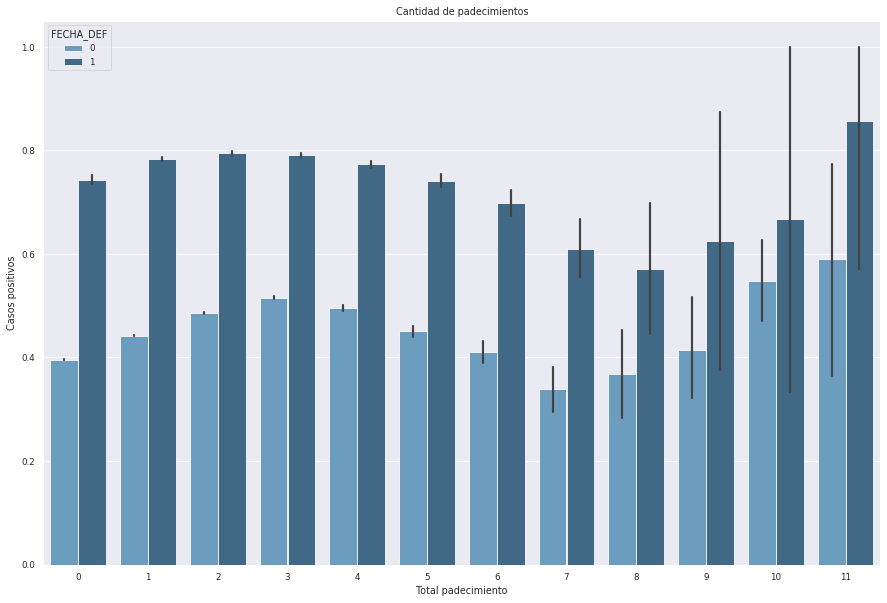

In [ ]:
g = sns.barplot(data = casos_mexico_tabla, x = casos_mexico_tabla['TOTAL_PADECIMIENTO'], y = casos_mexico_tabla['CLASIFICACION_FINAL'], hue = casos_mexico_tabla['FECHA_DEF'], palette="Blues_d")
g.set_title("Cantidad de padecimientos")
g.set(xlabel='Total padecimiento', ylabel='Casos positivos');

Las personas que más han fallecido son las que van en el rando de 1 a 6 padecimientos, y nevamente los que tienen 10 o más. De igual manera las personas que no padecen niguna de las 11 enfermedades tambien figuran en la gráfica.

In [ ]:
casos_mexico_tabla['FECHA_DEF'].sum()

149268

In [ ]:
#Se acomoda una tabla para poder tener los padecimientos por tipo de paciente, ambulatorios y hospitalizados que han fallecido o pudieron vivir 
prueba = casos_mexico_tabla[(casos_mexico_tabla['CLASIFICACION_FINAL']==1)]

In [ ]:
prueba = prueba.groupby( by = ['FECHA_DEF','TIPO_PACIENTE']).agg({'NEUMONIA':'sum','DIABETES':'sum','EPOC':'sum','ASMA':'sum','INMUSUPR':'sum','HIPERTENSION':'sum','CARDIOVASCULAR':'sum','OBESIDAD':'sum','RENAL_CRONICA':'sum','TABAQUISMO':'sum','OTRA_COM':'sum'}).reset_index()


In [ ]:
prueba = prueba.T

In [ ]:
#prueba

In [ ]:
prueba.columns = ['P_ambul', 'P_hosp', 'P_ambul_fal', 'P_hosp_fal']

In [ ]:
prueba = prueba.drop(['FECHA_DEF','TIPO_PACIENTE'],axis=0)

In [ ]:
prueba = prueba.reset_index()


In [ ]:
prueba.columns = ['Padecimiento','P_ambul', 'P_hosp', 'P_ambul_fal', 'P_hosp_fal']

In [ ]:
prueba

,Padecimiento,P_ambul,P_hosp,P_ambul_fal,P_hosp_fal
0,NEUMONIA,20778,84352,6151,70941
1,DIABETES,79188,42107,4024,36836
2,EPOC,5381,4187,505,4521
3,ASMA,22184,3376,238,1818
4,INMUSUPR,5421,3075,237,2373
5,HIPERTENSION,111648,47195,4767,43506
6,CARDIOVASCULAR,9435,5195,580,5097
7,OBESIDAD,129636,31971,2802,22364
8,RENAL_CRONICA,6025,5810,729,7053
9,TABAQUISMO,62707,10864,778,7669
